# Copypasta

In [1]:
import sys
sys.path.append('/trinity/home/i.zakazov/domain_adaptation_mri')

import os
from os.path import join as jp
from itertools import product

import pandas as pd
import numpy as np

import nibabel as nib
from tqdm import tqdm_notebook as tqdm

from dpipe.io import load
from dpipe.im.visualize import slice3d
from damri.utils import choose_root

img = 'images'
msk = 'masks'
root = '/gpfs/data/gpfs0/b.shirokikh/data/cc359'  
path_img = jp(root, img)
path_msk = jp(root, msk)

fnames = os.listdir(path_img)

cites = ('siemens', 'ge', 'philips')
tsls = ('15', '3')

pairs2fold = {p[1]: p[0] for p in list(enumerate(list(product(cites, tsls))))}

def fname2info(fname):
    f = fname.strip('.nii.gz')
    mask_fname = f + '_ss.nii.gz'
    _id, cite, tsl, *_ = f.split('_')
    return _id, cite, tsl, mask_fname

records = []
for fname in tqdm(fnames):
    _id, cite, tsl, mask_fname = fname2info(fname)
    x, y, z = nib.load(jp(path_img, fname)).header['pixdim'][1:4]
    record = {
        'id': _id,
        'MRI': jp(img, fname),
        'brain_mask': jp(msk, mask_fname),
        'fold': pairs2fold[(cite, tsl)],
        'tomograph_model': cite,
        'tesla_value': tsl,
        'x': x, 'y': y, 'z': z,
    }
    records.append(record)
    
from os.path import join as jp
data_path = '/gpfs/data/gpfs0/b.shirokikh/data/cc359'
meta = pd.read_csv(jp(data_path, 'meta.csv'), index_col='id')

/trinity/home/i.zakazov/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [44]:
domainOfScan = {}
scansOfDomain = {}
for record in records:
    scanID = record['id']
    domain = record['tomograph_model'] + record['tesla_value']
    if domain not in scansOfDomain.keys():
        scansOfDomain[domain]=[]
    scansOfDomain[domain].append(scanID)
    domainOfScan[scanID] = domain
    
domainNames = list(set(domainOfScan.values()))
domainNames.sort()
domainNames

['ge15', 'ge3', 'philips15', 'philips3', 'siemens15', 'siemens3']

# Baseline with CV3 (18 experiments)

In [45]:
import pandas as pd
cites = ('siemens', 'ge', 'philips')
tsls = ('15', '3')
domainNamesNew = [el1+el2 for (el1,el2) in list(product(cites, tsls))] 
domainNamesNew

['siemens15', 'siemens3', 'ge15', 'ge3', 'philips15', 'philips3']

In [46]:
#copy-pasted from here: 
# https://stackoverflow.com/questions/41476636/how-to-read-a-json-file-and-return-as-dictionary-in-python
import json

def js_r(filename):
    with open(filename) as f_in:
        return(json.load(f_in))

In [75]:
import pandas as pd

dom2exps = {}
for i, name in enumerate(domainNamesNew):
    dom2exps[name] = [3*i, 3*i+1, 3*i+2]

In [78]:
domainNames = domainNamesNew
diag = []
def getResults(metric, net, tolerance=1, withErr=True, retDict = False):
    
    if net=='unet2d':
        baseAddr = '/gpfs/gpfs0/i.zakazov/experiments/da/baseline_kfold_crossval_2Dunet/'
    elif net=='unet3d':
        baseAddr = '/gpfs/gpfs0/i.zakazov/experiments/da/baseline_kfold_crossval_3Dunet/'
    
    results = {}
    results_std = {}
        
    for n in domainNames:

        averageMetric4dom = {}
        stdMetric4dom = {}

        for name in domainNames:
            averageMetric4dom[name] = []
            stdMetric4dom[name] = []

        for i in dom2exps[n]:
            if metric=='dice':
                diceAddr = baseAddr + 'experiment_%d/test_metrics/dice_score.json'%i
            else:
                diceAddr = baseAddr + 'experiment_%d/test_metrics/sdice_score_tol_%d.json'%(i,tolerance)
            dices = js_r(diceAddr)
            for scan in dices.keys():
                domain = domainOfScan[scan]
                averageMetric4dom[domain].append(dices[scan])
                if n==domain:
                    diag.append(dices[scan])

        for domain in domainNames:
            #print(len(averageMetric4dom[domain]))
            stdMetric4dom[domain] = np.array(averageMetric4dom[domain]).std()#.round(2)
            averageMetric4dom[domain] = np.array(averageMetric4dom[domain]).mean()#.round(2)

        results[n] = averageMetric4dom
        results_std[n] = stdMetric4dom 

    val = pd.DataFrame.from_dict(results)
    err = pd.DataFrame.from_dict(results_std)

    if withErr:
        for n1 in domainNames:
            for n2 in domainNames:
                val[n1][n2] = str(round(val[n1][n2],2)) + '+-' + str(round(err[n1][n2],2))
     
    if retDict == False:
        if metric=='dice':
            return val.rename(index={name: name + '_dice_' + net for name in domainNames})         
        else:
            return val.rename(index={name: name + '_sDice_' + str(tolerance) + '_' + net for name in domainNames})
    else:
        return (results, results_std)

In [77]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

sdice1 = getResults('sdice', 'unet2d', 1, withErr=False)
sdice1.style.background_gradient(cmap=cm)

,siemens15,siemens3,ge15,ge3,philips15,philips3
siemens15_sDice_1_unet2d,0.848044,0.522768,0.687346,0.555972,0.693467,0.720897
siemens3_sDice_1_unet2d,0.684586,0.880677,0.693536,0.612247,0.546542,0.649652
ge15_sDice_1_unet2d,0.397575,0.100219,0.866190,0.279815,0.539676,0.517639
ge3_sDice_1_unet2d,0.789657,0.645836,0.627640,0.887094,0.662978,0.681703
philips15_sDice_1_unet2d,0.649478,0.278191,0.856386,0.427717,0.894273,0.511917
philips3_sDice_1_unet2d,0.512421,0.351745,0.675594,0.345022,0.410027,0.863623


In [81]:
np.array(diag)

array([], dtype=float64)

# Baseline one2all

In [50]:
one2allDomains = ['siemens15', 'siemens3', 'ge15', 'ge3', 'philips15', 'philips3']
def getResults_one2all(metric, net='unet3d', tolerance=1, withErr=True, retDict=False):
    
    if net=='unet3d':
        baseAddr = '/gpfs/gpfs0/b.shirokikh/experiments/da/paper_3d/unet3d_one2all/'
    elif net=='unet2d':
        baseAddr = '/gpfs/gpfs0/b.shirokikh/experiments/da/paper_2d/unet2d_one2all/'
    
    results = {}
    results_std = {}

    for exp_n, n in enumerate(one2allDomains):

        averageMetric4dom = {}
        stdMetric4dom = {}

        for name in one2allDomains:
            averageMetric4dom[name] = []
            #stdMetric4dom[name] = []

        if metric=='dice':
            diceAddr = baseAddr + 'experiment_%d/test_metrics/dice_score.json'%exp_n
        else:
            diceAddr = baseAddr + 'experiment_%d/test_metrics/sdice_score.json'%exp_n
        dices = js_r(diceAddr)
        for scan in dices.keys():
            domain = domainOfScan[scan]
            averageMetric4dom[domain].append(dices[scan])

        for domain in one2allDomains:        
            stdMetric4dom[domain] = np.array(averageMetric4dom[domain]).std()#.round(2)
            averageMetric4dom[domain] = np.array(averageMetric4dom[domain]).mean()#.round(2)

        results[n] = averageMetric4dom
        results_std[n] = stdMetric4dom 

    val = pd.DataFrame.from_dict(results)
    err = pd.DataFrame.from_dict(results_std)

    if withErr:
        for n1 in one2allDomains:
            for n2 in one2allDomains:
                val[n1][n2] = str(val[n1][n2]) + '+-' + str(err[n1][n2])
    
    if not retDict:
        if metric=='dice':
            return val.rename(index={name: name + '_dice_' + net for name in one2allDomains})         
        else:
            return val.rename(index={name: name + '_sDice_' + str(tolerance) + '_' + net for name in one2allDomains})
        
    else:
        return (results, results_std)

In [51]:
sdice1_allDomain = getResults_one2all('sdice','unet2d', withErr=False)
sdice1_allDomain.style.background_gradient(cmap=cm)

/trinity/home/i.zakazov/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/trinity/home/i.zakazov/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/trinity/home/i.zakazov/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/trinity/home/i.zakazov/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice.
/trinity/home/i.zakazov/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,siemens15,siemens3,ge15,ge3,philips15,philips3
siemens15_sDice_1_unet2d,nan,0.508175,0.717723,0.563143,0.705878,0.706571
siemens3_sDice_1_unet2d,0.719652,nan,0.698643,0.667699,0.633299,0.663074
ge15_sDice_1_unet2d,0.390694,0.090998,nan,0.295944,0.554587,0.481358
ge3_sDice_1_unet2d,0.798028,0.627664,0.662275,nan,0.672087,0.665904
philips15_sDice_1_unet2d,0.630458,0.245912,0.865359,0.425965,nan,0.460751
philips3_sDice_1_unet2d,0.542732,0.343421,0.698350,0.371684,0.468458,nan


# Experiments based on one2all

In [52]:
domainNamesNew

['siemens15', 'siemens3', 'ge15', 'ge3', 'philips15', 'philips3']

In [53]:
i = 0
pair2exps = {}
for name1 in domainNamesNew:
    for name2 in domainNamesNew:
        if name1 != name2:
            pair2exps[(name1, name2)] = [i]
            i+=1

In [54]:
def getResultsPaper(metric, addr, net, withErr=True, retDict = False):
    
    baseAddr = addr
    
    averageMetric4dom = {}
    stdMetric4dom = {}

    for name1 in domainNamesNew:
        for name2 in domainNamesNew:
            averageMetric4dom[(name1, name2)] = []
            stdMetric4dom[(name1, name2)] = []

    for n1 in domainNamesNew:
        for n2 in domainNamesNew:
            if n1 != n2:
                for i in pair2exps[(n1,n2)]:
                    
                    if metric=='dice':
                        diceAddr = baseAddr + '/experiment_%d/test_metrics/dice_score.json'%i
                    else:
                        diceAddr = baseAddr + '/experiment_%d/test_metrics/sdice_score.json'%i
                    dices = js_r(diceAddr) #here 'dices' stand for an arbitary metric
                    
                    for scan in dices.keys():
                        domain = domainOfScan[scan]
                        if domain == n1: # base domain
                            #print(averageMetric4dom[(n1, n1)])
                            averageMetric4dom[(n1, n1)].append(dices[scan])
                        elif domain == n2: #new domain
                            averageMetric4dom[(n1, n2)].append(dices[scan])
                    
                stdMetric4dom[(n1, n2)] = np.array(averageMetric4dom[(n1, n2)]).std()
                averageMetric4dom[(n1, n2)] = np.array(averageMetric4dom[(n1, n2)]).mean()
     
    for n1 in domainNamesNew: #changes in the base domain perfomance are collected here
        stdMetric4dom[(n1, n1)] = np.array(averageMetric4dom[(n1, n1)]).std()
        averageMetric4dom[(n1, n1)] = np.array(averageMetric4dom[(n1, n1)]).mean() 
        
    res = {}
    res_std = {}
    for name1 in domainNamesNew:
        res[name1] = {}
        res_std[name1] = {}
  
        for name2 in domainNamesNew:
            res[name1][name2] = averageMetric4dom[(name1,name2)]
            res_std[name1][name2] = stdMetric4dom[(name1,name2)]

    val = pd.DataFrame.from_dict(res)
    err = pd.DataFrame.from_dict(res_std)

#     return val, err

#     if withErr:
#         for n1 in domainNamesNew:
#             for n2 in domainNamesNew:
#                 val[n1][n2] = str(val[n1][n2]) + '+-' + str(err[n1][n2])
    
    if retDict == False:    
        if metric=='dice':
            return val.rename(index={name: name + '_dice' for name in domainNamesNew})         
        else:
            if net=='unet2d':
                return val.rename(index={name: name + '_sDice_1_unet2d' for name in domainNamesNew})
            else:
                return val.rename(index={name: name + '_sDice_1_unet3d' for name in domainNamesNew})
    else:
        return (averageMetric4dom, stdMetric4dom)  

### Partial Freezing (3D u-net)

In [55]:
base = '/gpfs/gpfs0/i.zakazov/experiments/da/middleFreeze/'

exp = ['unfreeze_down1',
 'unfreeze_down2',
 'unfreeze_down3',
 'unfreeze_up1',
 'unfreeze_up2',
 'unfreeze_up3']

resDict = {}
for experiment in exp[:-1]: #exluding up3 which I did not test because of the intersection
    path = base + experiment
    resDict[experiment] = getResultsPaper('sdice', path, 'unet3d', withErr=True, retDict = True)
    
resWerr = {}
resWerr['baseline'] = {}
sdice1Dict = getResults_one2all('sdice', 'unet3d', 1, withErr=False, retDict=True)
for n1 in domainNamesNew:
    for n2 in domainNamesNew:
        if n1 != n2:
            name = n1 + '_' + n2
            val = sdice1Dict[0][n1][n2].round(2)
            err = sdice1Dict[1][n1][n2].round(2)
            entry = str(val) + '+-' + str(err)
            resWerr['baseline'][name] = entry
            
import math as m
for experiment in exp[:-1]:
    nameExp = experiment
    resWerr[nameExp] = {}
    for key in resDict[nameExp][0].keys():
        name = key[0] + '_' + key[1]
        val = resDict[nameExp][0][key].round(2)
        err = resDict[nameExp][1][key].round(2)
        if not m.isnan(val):
            entry = str(val) + '+-' + str(err)
            resWerr[nameExp][name] = entry
                
partFreeze = pd.DataFrame.from_dict(resWerr)

/trinity/home/i.zakazov/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice.
/trinity/home/i.zakazov/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice.


### Main results (2D u-net)

In [56]:
roundN = 2

base = '/gpfs/gpfs0/b.shirokikh/experiments/da/paper_final/'
exp = ['joint', 'posttrain', 'unfreeze_first', 'unfreeze_last']
data = ['3', '1', '1_2', '1_3', '1_6', '1_12', '1_24', 'slice']

resDict = {}
notAvalExps = []

for experiment in exp:
    for addScans in data: 
        name = experiment + addScans
        path = base + addScans + '/' + experiment
        # WE MUST CATCH EXCEPTION HERE (SOME EXPERIMENTS ARE NOT CARRIED OUT)
        try:
            resDict[name] = getResultsPaper('sdice', path, 'unet2d', withErr=True, retDict = True)
        except FileNotFoundError:
            notAvalExps.append(name)
            print('no experiment:', name)

resWerr = {} #the final sheet

resWerr['baseline'] = {}
sdice1Dict = getResults_one2all('sdice', 'unet2d', 1, withErr=False, retDict=True)
for n1 in domainNamesNew:
    for n2 in domainNamesNew:
        if n1 != n2:
            name = n1 + '_' + n2
            val = sdice1Dict[0][n1][n2].round(roundN)
            err = sdice1Dict[1][n1][n2].round(roundN)
            entry = str(val) + '+-' + str(err)
            resWerr['baseline'][name] = entry
            
for addScans in data: 
    for experiment in exp:
        nameExp = experiment + addScans
        if nameExp not in notAvalExps:
            resWerr[nameExp] = {}
            for key in resDict[nameExp][0].keys():
                name = key[0] + '_' + key[1]
                val = resDict[nameExp][0][key].round(roundN)
                err = resDict[nameExp][1][key].round(roundN)
                if not m.isnan(val):
                    entry = str(val) + '+-' + str(err)
                    resWerr[nameExp][name] = entry             

no experiment: joint3
no experiment: joint1_2
no experiment: joint1_3
no experiment: joint1_6
no experiment: joint1_12
no experiment: joint1_24
no experiment: jointslice
no experiment: posttrain1_3
no experiment: posttrain1_6
no experiment: posttrain1_12
no experiment: unfreeze_first1_2
no experiment: unfreeze_first1_3
no experiment: unfreeze_first1_6
no experiment: unfreeze_last1_2
no experiment: unfreeze_last1_6


/trinity/home/i.zakazov/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice.
/trinity/home/i.zakazov/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice.


In [57]:
ultimate2d = pd.DataFrame.from_dict(resWerr)

# Analysis of experiments based on one2all

In [58]:
def stripOfErr(a):
    if type(a) == np.ndarray:
        b = []
        for el in a:
            b.append(float(el.split('+')[0]))
        return np.array(b)
    elif type(a) == str:
        return float(a.split('+')[0])
    
def highlight_max(x):
    return ['background-color: yellow' if stripOfErr(v)==max(stripOfErr(x.values)) else '' for v in x]

In [59]:
sdice1 = getResults('sdice', 'unet2d', 1, withErr=True)

baselineUp = {}
for domain in domainNamesNew:
    baselineUp[domain] = sdice1.to_dict()[domain][domain+'_sDice_1_unet2d']
    
baselineUpColumn = []
for domain in domainNamesNew:
    for i in range(5):
        baselineUpColumn.append(baselineUp[domain])
        
ultimate2d['baselineUp'] = baselineUpColumn

ultimate2d = ultimate2d[[ultimate2d.columns.to_list()[-1], *ultimate2d.columns.to_list()[:-1]]]

/trinity/home/i.zakazov/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/trinity/home/i.zakazov/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [60]:
ultimate2dCopy = ultimate2d.copy()
ultimate2dCopy = ultimate2dCopy.applymap(stripOfErr)

exps = list(ultimate2dCopy)
exps.remove('baseline')

for exp in exps:
    ultimate2dCopy[exp+'-baseline'] = ultimate2dCopy[exp] - ultimate2dCopy['baseline']
    
for exp in exps:
    ultimate2dCopy[exp+'Rel'] = ultimate2dCopy[exp+'-baseline']/ultimate2dCopy['baselineUp'+'-baseline']
    
for col in list(ultimate2dCopy):
    if col[-3:]!='Rel':
        ultimate2dCopy = ultimate2dCopy.drop(columns=[col,])
        
ultimate2dCopy = ultimate2dCopy.drop(['ge15_philips15',])

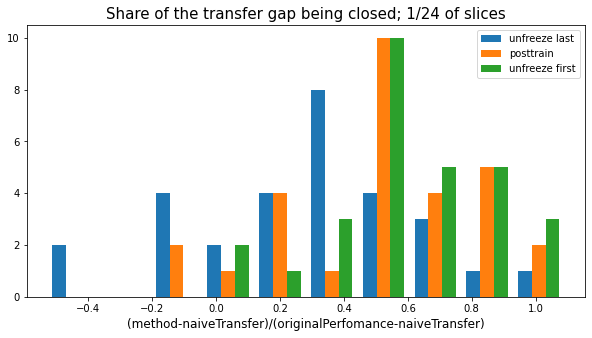

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.hist((ultimate2dCopy['unfreeze_last1_24Rel'], ultimate2dCopy['posttrain1_24Rel'],\
          ultimate2dCopy['unfreeze_first1_24Rel']),label=('unfreeze last', 'posttrain', 'unfreeze first'))
plt.title('Share of the transfer gap being closed; 1/24 of slices', fontsize=15)
plt.xlabel('(method-naiveTransfer)/(originalPerfomance-naiveTransfer)', fontsize=12)
plt.legend()
plt.show()

In [67]:
def x(interval):
    return((250 // interval) * interval)

In [68]:
x(2)

250

In [69]:
250//2

125

In [70]:
a=2